In [1]:
# qubit reset: Analysis of probability ['0'] vs number of resets:       
#This cell has function which can produce circuit of qubit reset, num_reset times
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister,transpile
from qiskit.circuit.classical import expr
def get_qubit_reset(num_resets):
    cr1=ClassicalRegister(1,name="cr1")     # for mid circuit measurement    
    qr=QuantumRegister(1,name="qr")
    qc=QuantumCircuit(qr,cr1)
    # initialization
    qc.h(0)    
    for i in range(num_resets):
        # mid Circuit Measurement
        qc.measure(qr[0],cr1[0])
        parity= expr.lift(cr1[0])
        #feed forward operation
        with qc.if_test(parity):
            qc.x(qr[0])
    qc.measure(qr[0],cr1[0])               # Final measurement
    return qc

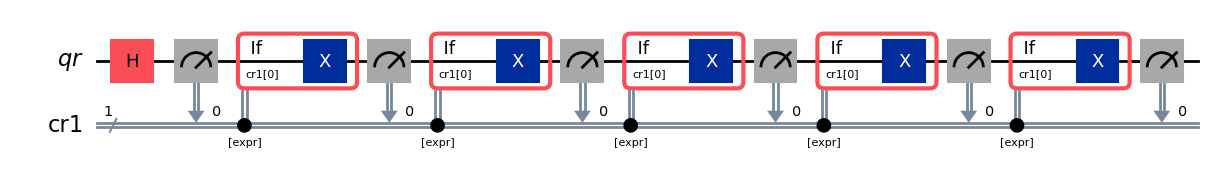

In [2]:
# This cell is for testing whether we succeded in previous cell
qc=get_qubit_reset(5)
qc.draw("mpl")

In [9]:
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler, QiskitRuntimeService
service = QiskitRuntimeService()
# Specify a system to use for the noise model
real_backend = service.backend("ibm_kyoto")
aer = AerSimulator.from_backend(real_backend)
 
# Run the sampler job locally using AerSimulator.
pm = generate_preset_pass_manager(backend=aer, optimization_level=1)

max_num_reset=10
qc_transpiled_list=[]
num_reset_list=list(range(1,max_num_reset+1))
for num_reset in num_reset_list:
    for i in range(10):                     # for taking 10 copies of each circuit , needed for taking mean, standard deviation of the probability ['0']
        circuit=get_qubit_reset(num_reset)   # However, all 10 outputs will be same (seed is fixed)
        isa_qc = pm.run(circuit)
        qc_transpiled_list.append(isa_qc)
sampler = Sampler(backend=aer)
result = sampler.run(qc_transpiled_list).result()

csen6e1tj7dg008cjwd0


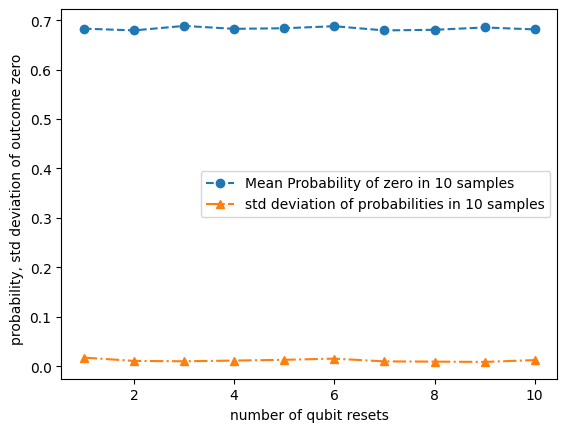

In [10]:
# post processing
import matplotlib.pyplot as plt
import statistics
list_std_deviation_prob_zero=[]
list_mean_prob_zero=[]
list_probs=[]                             # we will fill here our probabilities of zero corresponding to number of qubit resets 
for i in range(0,len(num_reset_list)):
    for j in range(10):
        data = result[10*i+j].data             
        counts=data.cr1.get_counts()
        total_counts=data.cr1.num_shots
        prob_zero=(counts['0'])/total_counts
        list_probs.append(prob_zero)
    list_mean_prob_zero.append(statistics.mean(list_probs))
    list_std_deviation_prob_zero.append(statistics.stdev(list_probs))
    list_probs.clear()                                           # for next iteration use
plt.plot(num_reset_list,list_mean_prob_zero,'--o',label='Mean Probability of zero in 10 samples')
plt.plot(num_reset_list,list_std_deviation_prob_zero,'-.^',label='std deviation of probabilities in 10 samples')
plt.xlabel('number of qubit resets')
plt.ylabel('probability, std deviation of outcome zero  ')
plt.legend()

In [11]:
list_mean_prob_zero  # printing probability corresponding to different no of reset qubits operation (not expected this oscillation)

[0.6828125,
 0.67919921875,
 0.68828125,
 0.682421875,
 0.68359375,
 0.6876953125,
 0.67919921875,
 0.68046875,
 0.68515625,
 0.68125]

In [12]:
list_std_deviation_prob_zero

[0.01743771078999437,
 0.010788941028109733,
 0.009988770007297223,
 0.011433151780476662,
 0.012996396339633547,
 0.015356857167596898,
 0.009790008620978233,
 0.009319224274623353,
 0.008712776571560728,
 0.012448352502830334]